## EDA & PCA

In the last notebooks we cleaned the data and removed correlated and outlier columns.  
In this notebook we will try to reduce the visualize the data and use PCA to reduce dimensionality of the data even more.  

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
reduced_df = pd.read_csv('data/dataframes/df_after_cols_reduction.csv').iloc[:,1:]

cat_cols = ['company_name','company_about', 'founded', 'business model','employees','product stage','status','funding stage','succeeded']
num_cols = ['total_raised','total_rounds', 'investors','ipo_price', 'geo_market_per']

tag_cols = [col for col in reduced_df.columns if col.startswith('tag_')]
targetmarket_cols = [col for col in reduced_df.columns if col.startswith('targetmarket_')]
sector_list = [col for col in reduced_df.columns if col.startswith("sector_")]
target_ind_list = [col for col in reduced_df.columns if col.startswith("industry_")]
technology_list = [col for col in reduced_df.columns if col.startswith("technology_")]

bin_cols = tag_cols + targetmarket_cols + sector_list + target_ind_list + technology_list

print(f'Data after reduction: {reduced_df.shape}')

Data after reduction: (10070, 1927)


In [3]:
print("Number of categorical columns: ", len(cat_cols))
print('Number of numerical columns: ',len(num_cols))

print("Number of binary columns in reduced data: ", len(bin_cols))


Number of categorical columns:  9
Number of numerical columns:  5
Number of binary columns in reduced data:  1913


Besided 14 categorical and numerical columns, we see there are **1913** binary columns in our reduced dimentions data.  

We can divide the binary columns into 5 groups as before:  
<li> The company's tags columns.</li>
<li> The company's target markets columns.</li>
<li> The company's sectors columns.</li>
<li> The company's target industries columns.</li>
<li> The company's used technologies columns.</li>


We can use pie plots to visualize categorical properties: 

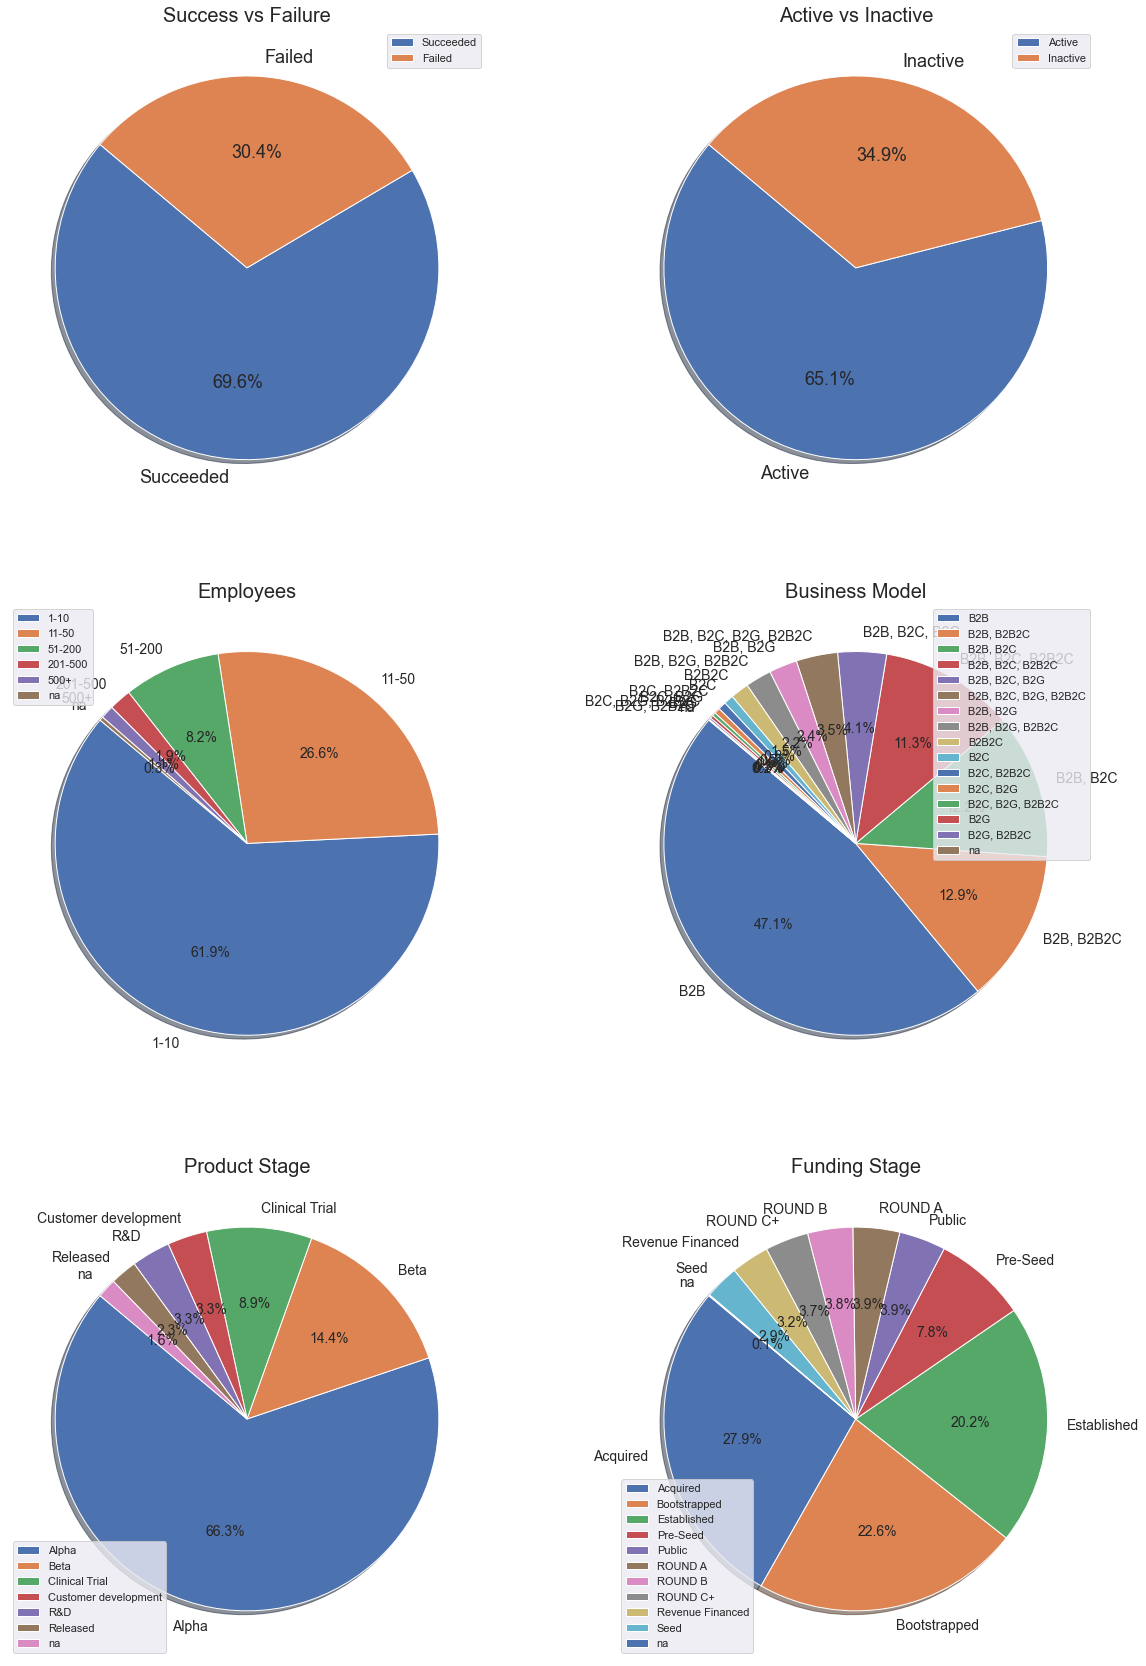

In [4]:
success_label = ['Succeeded', 'Failed']
business_model_labels = ['B2B', 'B2B, B2B2C', 'B2B, B2C', 'B2B, B2C, B2B2C', 'B2B, B2C, B2G',
 'B2B, B2C, B2G, B2B2C', 'B2B, B2G', 'B2B, B2G, B2B2C', 'B2B2C', 'B2C',
 'B2C, B2B2C', 'B2C, B2G', 'B2C, B2G, B2B2C', 'B2G', 'B2G, B2B2C', 'na']
product_stage_labels = ['Alpha', 'Beta', 'Clinical Trial', 'Customer development', 'R&D', 'Released', 'na']
funding_stage_labels = ['Acquired', 'Bootstrapped', 'Established', 'Pre-Seed', 'Public', 'ROUND A', 'ROUND B', 'ROUND C+', 'Revenue Financed', 'Seed', 'na']
employees_lable = ['1-10', '11-50', '51-200', '201-500', '500+', 'na']

def plot_pie(axe,data,labels,title, fontsize = 14):
    axe.pie(data, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': fontsize})
    axe.set_title(title, fontsize=20)
    axe.legend(labels, loc='best')
    return axe

fig, axes = plt.subplots(3,2, figsize=(20,30))

axes[0,0] = plot_pie(axes[0,0], reduced_df['succeeded'].value_counts().values, success_label, 'Success vs Failure', 18)
axes[0,1] = plot_pie(axes[0,1], reduced_df['status'].value_counts().values, ['Active','Inactive'], 'Active vs Inactive', 18)
axes[1,0] = plot_pie(axes[1,0], reduced_df['employees'].value_counts().values, employees_lable, 'Employees')
axes[1,1] = plot_pie(axes[1,1], reduced_df['business model'].value_counts().values, business_model_labels, 'Business Model')
axes[2,0] = plot_pie(axes[2,0], reduced_df['product stage'].value_counts().values, product_stage_labels, 'Product Stage')
axes[2,1] = plot_pie(axes[2,1], reduced_df['funding stage'].value_counts().values, funding_stage_labels, 'Funding Stage')


We can also see the success rate by the years according to founded and succeeded columns:  
In the **catplot** below we can observe the peak in the success rate at the year 2016 where we can see that the Gausian bell is beautifully being formed.  
The reasons why the success rates may have dropped vary, but our guesses are that they might have:
1. Dropped since the outbreak of covid-19 which might explain the drop in the years 2020 and fourth, which leads us to number 2.
2. The companies that have founded since the year 2016 might not have run long enough to succeed. Or in other words, theres a long way to the top if you wanna Rock-N'-Roll.

Side note: We see that the peak of the bell is at 2016. It's interesting wether there was a major technological / market breakthrough in that year that might have caused the peak.
Or maybe it's because we havn't waited long enough 🙂

The records here includes the companies that have founded since 2000 and not beforehand.


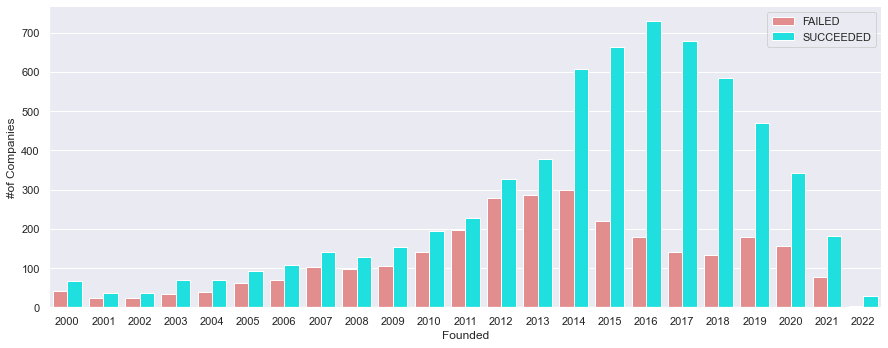

In [5]:
g = sns.catplot(
    x='founded', 
    data=reduced_df[reduced_df.founded >= 2000],
    kind='count', 
    hue='succeeded',
    palette=["lightcoral", "cyan"], 
    height=5, 
    aspect=2.5,
    legend=False,
    ).set_axis_labels('Founded', '#of Companies')
g.ax.legend(labels=['FAILED', 'SUCCEEDED'])

Lets try to visualize the most used tags in each group:

In [6]:

import plotly.express as px

def get_sum_dict(df, cols):
        sum_dict ={}
        for col in cols:
            sum_dict[col] = df[col].sum()
        return sum_dict


def get_most_used(sum_dict, n):
    sorted_dict = sorted(sum_dict.items(), key=lambda x: x[1], reverse=True)
    d = {x[0].split('_')[-1].replace('-',' ').capitalize():x[1] for x in sorted_dict[:n]}
    # d['Other'] = sum(i[1] for i in sorted_dict[n:])
    return d

def plotly_most_used(most_used, category_name):
    df_most_used = pd.DataFrame(data={'Tag': list(most_used.keys()), 'Sum of Tag': list(most_used.values())})
    fig = px.bar(df_most_used, x='Tag', y='Sum of Tag', text_auto='.2s', title=f'20 Most Used {category_name}')
    fig.show()
    

In [7]:


tag_most_used = get_most_used(get_sum_dict(reduced_df, tag_cols),20)
tech_most_used = get_most_used(get_sum_dict(reduced_df, technology_list),20)
sector_most_used = get_most_used(get_sum_dict(reduced_df, sector_list),20)

plotly_most_used(tag_most_used, "Tags")
plotly_most_used(tech_most_used, "Technologies")
plotly_most_used(sector_most_used, "Sectors")


In the top 3 of each category we can observe that the most used properties are:  <br/><br/><br/>
**Most used tags:**
1. Mobile Application
2. Artificial Intelligence
3. Enterprise Solutions

**Most used Technologies:**
1. Platforms & Interfaces
2. Web
3. Mobile

**Sectors:**
1. Life Sciences & Healthcare
2. Enterprise, IT & Data Infrastructure
3. Retail & Marketing


# PCA  
### Now we can try to reduce the dimensionality of the data using PCA.

Lets check the optimum number of components for PCA,  
We will plot the explained variance ratio first for the entire binary dataset,  
And then plot the explained variance ratio for each columns group.

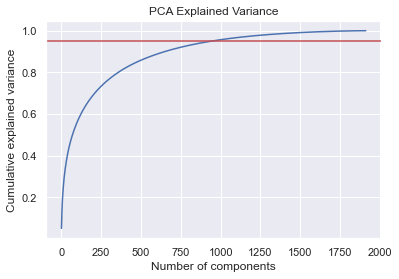

In [8]:

pca = PCA().fit(reduced_df[bin_cols])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA Explained Variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='-')


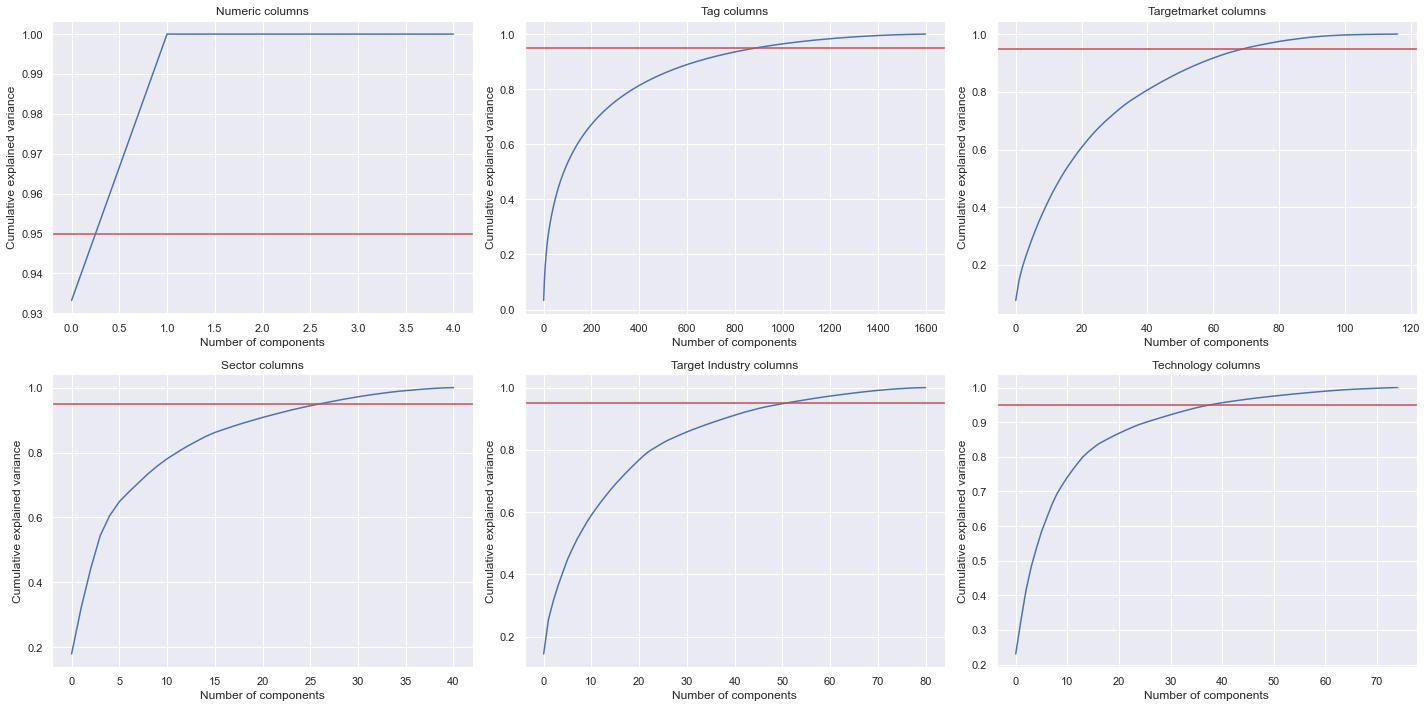

In [13]:
cols_dict = {'Numeric columns':num_cols, 'Tag columns':tag_cols, 'Targetmarket columns': targetmarket_cols, 'Sector columns':sector_list,
 'Target Industry columns':target_ind_list,'Technology columns':technology_list}

fig, ax = plt.subplots(2, 3, figsize=(20,10))

for i, (key, value) in enumerate(cols_dict.items()):
    pca = PCA().fit(reduced_df[value])

    ax[i//3, i%3].set_title(key)
    ax[i//3, i%3].plot(np.cumsum(pca.explained_variance_ratio_))

    ax[i//3, i%3].set_xlabel('Number of components')
    ax[i//3, i%3].set_ylabel('Cumulative explained variance')
    ax[i//3, i%3].axhline(y=0.95, color='r', linestyle='-')

plt.tight_layout()


Our desired cutoff for the number of components is **0.95** - marked in as a red line in the above plots.  
Now we will build our PCA model and fit it to each of the columns group:

In [10]:
pca_df = reduced_df[cat_cols]
for key, cols in cols_dict.items():
    pca = PCA(0.95).fit_transform(reduced_df[cols])
    print(f'Number of components for {key}: {pca.shape[1]}')
    pca_df = pd.concat([pca_df, pd.DataFrame(pca, columns=[f'{key}_{_}' for _ in range(pca.shape[1])])], axis=1)

print('-----------------------------------------------------')
print(f'PCA dataframe shape is: {pca_df.shape}')

Number of components for Numeric columns: 2
Number of components for Tag columns: 892
Number of components for Targetmarket columns: 71
Number of components for Sector columns: 28
Number of components for Target Industry columns: 52
Number of components for Technology columns: 39
-----------------------------------------------------
PCA dataframe shape is: (10070, 1093)


PCA is done on all the **binary** columns devided by groups.  
We have stayed with **1093** columns after the pca model. 

In [11]:
pca_df.to_csv('data/dataframes/pca_df.csv')

In this notebook we took the big dataframe with **over 1900 binary columns,** and reduced its dimensionality to **1093** using PCA algorithm.    
For the next and final notebook, we will use supervised learning algorithms on our PCA dataframe.  
Next notebook: [Supervised Learning](5-supervised.ipynb)